<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S10/blob/master/S10_Trial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

**<h2>Install Albumentations and Apex librabies</h2>**

In [2]:
!pip install -U git+https://github.com/albu/albumentations
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-llf64nut
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-llf64nut
     |████████████████████████████████| 634kB 4.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=2ca9cb39371bdc4b453908addb17f381d0e565492ccef4c09eaef51fa8049268
  Stored in directory: /tmp/pip-ephem-wheel-cache-7mw71p2x/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=ca292dd2a325a098fa78cf7556d8fd1812f74875a9d3c6245d7c649e8e8b6165
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session10'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



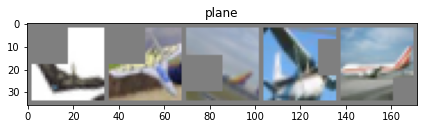

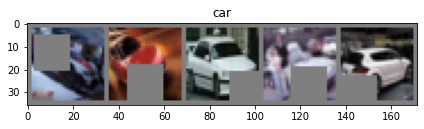

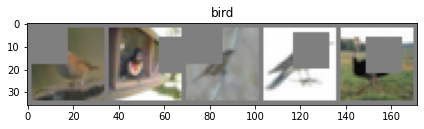

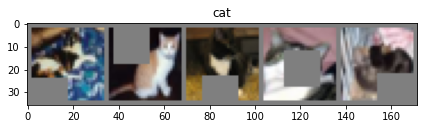

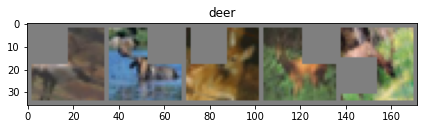

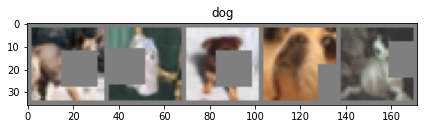

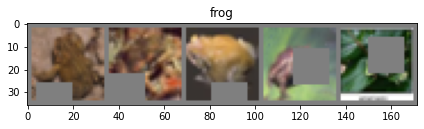

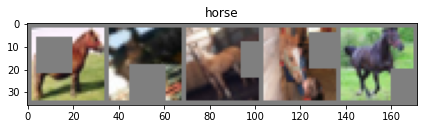

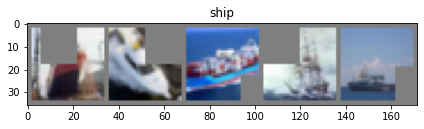

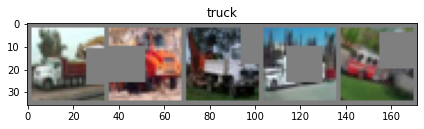

In [7]:
show_images.show_random_images(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(resnet.parameters(), lr=0.001,momentum=0.9, weight_decay=0.0005)
lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=600 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


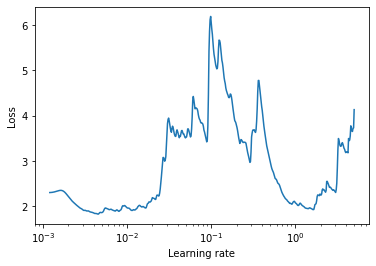

In [10]:
lrfinder.plot()

In [11]:
Best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(Best_lr)

0.004501252062061337


In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.00005)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, min_lr=1e-4)

In [14]:
train_loss=[]
train_acc=[]
EPOCHS = 50

for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
      train_loss, train_acc = train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
      test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
      scheduler.step(test_loss[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.004501252062061337


Loss=1.611937165260315 Batch_id=390 Accuracy=43.70: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6049/10000 (60.49%)

EPOCH: 2 LR: 0.004501252062061337


Loss=1.100475549697876 Batch_id=390 Accuracy=58.68: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6557/10000 (65.57%)

EPOCH: 3 LR: 0.004501252062061337


Loss=0.9784740209579468 Batch_id=390 Accuracy=64.95: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7117/10000 (71.17%)

EPOCH: 4 LR: 0.004501252062061337


Loss=0.6967223882675171 Batch_id=390 Accuracy=69.20: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7353/10000 (73.53%)

EPOCH: 5 LR: 0.004501252062061337


Loss=0.6659101843833923 Batch_id=390 Accuracy=71.68: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7789/10000 (77.89%)

EPOCH: 6 LR: 0.004501252062061337


Loss=0.6563833951950073 Batch_id=390 Accuracy=73.88: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7945/10000 (79.45%)

EPOCH: 7 LR: 0.004501252062061337


Loss=0.6079127788543701 Batch_id=390 Accuracy=75.74: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7722/10000 (77.22%)

EPOCH: 8 LR: 0.004501252062061337


Loss=0.48573723435401917 Batch_id=390 Accuracy=77.03: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8254/10000 (82.54%)

EPOCH: 9 LR: 0.004501252062061337


Loss=0.7012313604354858 Batch_id=390 Accuracy=78.08: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8266/10000 (82.66%)

EPOCH: 10 LR: 0.004501252062061337


Loss=0.6181994080543518 Batch_id=390 Accuracy=79.37: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8115/10000 (81.15%)

EPOCH: 11 LR: 0.004501252062061337


Loss=0.6444559097290039 Batch_id=390 Accuracy=80.41: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8249/10000 (82.49%)

EPOCH: 12 LR: 0.004501252062061337


Loss=0.5569247007369995 Batch_id=390 Accuracy=80.94: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8525/10000 (85.25%)

EPOCH: 13 LR: 0.004501252062061337


Loss=0.7001091241836548 Batch_id=390 Accuracy=81.89: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8512/10000 (85.12%)

EPOCH: 14 LR: 0.004501252062061337


Loss=0.4140976369380951 Batch_id=390 Accuracy=82.36: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8500/10000 (85.00%)

EPOCH: 15 LR: 0.004501252062061337


Loss=0.48372286558151245 Batch_id=390 Accuracy=82.96: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8469/10000 (84.69%)

EPOCH: 16 LR: 0.004501252062061337


Loss=0.4484170973300934 Batch_id=390 Accuracy=83.76: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8611/10000 (86.11%)

EPOCH: 17 LR: 0.004501252062061337


Loss=0.28369781374931335 Batch_id=390 Accuracy=84.31: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8408/10000 (84.08%)

EPOCH: 18 LR: 0.004501252062061337


Loss=0.538913905620575 Batch_id=390 Accuracy=84.83: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8645/10000 (86.45%)

EPOCH: 19 LR: 0.004501252062061337


Loss=0.58338862657547 Batch_id=390 Accuracy=85.06: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8587/10000 (85.87%)

EPOCH: 20 LR: 0.004501252062061337


Loss=0.3915957808494568 Batch_id=390 Accuracy=85.66: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8790/10000 (87.90%)

EPOCH: 21 LR: 0.004501252062061337


Loss=0.3561774790287018 Batch_id=390 Accuracy=86.19: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8776/10000 (87.76%)

EPOCH: 22 LR: 0.004501252062061337


Loss=0.2832431197166443 Batch_id=390 Accuracy=86.60: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8731/10000 (87.31%)

EPOCH: 23 LR: 0.004501252062061337


Loss=0.3522152304649353 Batch_id=390 Accuracy=86.93: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8672/10000 (86.72%)

EPOCH: 24 LR: 0.004501252062061337


Loss=0.5335142612457275 Batch_id=390 Accuracy=87.28: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8754/10000 (87.54%)

EPOCH: 25 LR: 0.004501252062061337


Loss=0.4223257005214691 Batch_id=390 Accuracy=87.62: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8756/10000 (87.56%)

EPOCH: 26 LR: 0.004501252062061337


Loss=0.2980431020259857 Batch_id=390 Accuracy=87.82: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8881/10000 (88.81%)

EPOCH: 27 LR: 0.004501252062061337


Loss=0.41182389855384827 Batch_id=390 Accuracy=88.40: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8883/10000 (88.83%)

EPOCH: 28 LR: 0.004501252062061337


Loss=0.40581709146499634 Batch_id=390 Accuracy=88.52: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8931/10000 (89.31%)

EPOCH: 29 LR: 0.004501252062061337


Loss=0.3927727937698364 Batch_id=390 Accuracy=88.89: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8931/10000 (89.31%)

EPOCH: 30 LR: 0.004501252062061337


Loss=0.32753729820251465 Batch_id=390 Accuracy=89.00: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8867/10000 (88.67%)

EPOCH: 31 LR: 0.004501252062061337


Loss=0.35616549849510193 Batch_id=390 Accuracy=89.41: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8817/10000 (88.17%)

EPOCH: 32 LR: 0.004501252062061337


Loss=0.4977790415287018 Batch_id=390 Accuracy=89.70: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8875/10000 (88.75%)

EPOCH: 33 LR: 0.004501252062061337


Loss=0.23530037701129913 Batch_id=390 Accuracy=89.90: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8927/10000 (89.27%)

EPOCH: 34 LR: 0.0004501252062061337


Loss=0.17864641547203064 Batch_id=390 Accuracy=92.20: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9126/10000 (91.26%)

EPOCH: 35 LR: 0.0004501252062061337


Loss=0.3982395529747009 Batch_id=390 Accuracy=92.91: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9169/10000 (91.69%)

EPOCH: 36 LR: 0.0004501252062061337


Loss=0.17974333465099335 Batch_id=390 Accuracy=93.08: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9141/10000 (91.41%)

EPOCH: 37 LR: 0.0004501252062061337


Loss=0.14548729360103607 Batch_id=390 Accuracy=93.30: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9157/10000 (91.57%)

EPOCH: 38 LR: 0.0004501252062061337


Loss=0.25304481387138367 Batch_id=390 Accuracy=93.43: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9173/10000 (91.73%)

EPOCH: 39 LR: 0.0004501252062061337


Loss=0.27449679374694824 Batch_id=390 Accuracy=93.62: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9184/10000 (91.84%)

EPOCH: 40 LR: 0.0004501252062061337


Loss=0.22079405188560486 Batch_id=390 Accuracy=93.81: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9183/10000 (91.83%)

EPOCH: 41 LR: 0.0004501252062061337


Loss=0.21664071083068848 Batch_id=390 Accuracy=93.80: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9193/10000 (91.93%)

EPOCH: 42 LR: 0.0004501252062061337


Loss=0.20379705727100372 Batch_id=390 Accuracy=93.87: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9203/10000 (92.03%)

EPOCH: 43 LR: 0.0004501252062061337


Loss=0.09071175009012222 Batch_id=390 Accuracy=94.07: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9201/10000 (92.01%)

EPOCH: 44 LR: 0.0004501252062061337


Loss=0.15514019131660461 Batch_id=390 Accuracy=93.84: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9190/10000 (91.90%)

EPOCH: 45 LR: 0.0004501252062061337


Loss=0.11927662044763565 Batch_id=390 Accuracy=94.20: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9188/10000 (91.88%)

EPOCH: 46 LR: 0.0004501252062061337


Loss=0.16104266047477722 Batch_id=390 Accuracy=94.28: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9197/10000 (91.97%)

EPOCH: 47 LR: 0.0001


Loss=0.1759728193283081 Batch_id=390 Accuracy=94.37: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9203/10000 (92.03%)

EPOCH: 48 LR: 0.0001


Loss=0.07139965891838074 Batch_id=390 Accuracy=94.58: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9201/10000 (92.01%)

EPOCH: 49 LR: 0.0001


Loss=0.16561411321163177 Batch_id=390 Accuracy=94.58: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9186/10000 (91.86%)

EPOCH: 50 LR: 0.0001


Loss=0.1255112588405609 Batch_id=390 Accuracy=94.51: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s]



Test set: Average loss: 0.0020, Accuracy: 9207/10000 (92.07%)



In [15]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 92.070 %


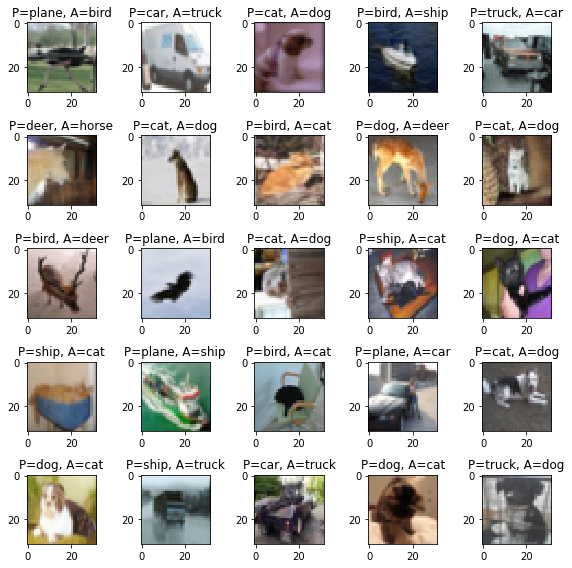

In [16]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [17]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 90 %
Accuracy of   car : 91 %
Accuracy of  bird : 92 %
Accuracy of   cat : 92 %
Accuracy of  deer : 100 %
Accuracy of   dog : 74 %
Accuracy of  frog : 97 %
Accuracy of horse : 100 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %


Text(0.5, 1.0, 'Test Accuracy')

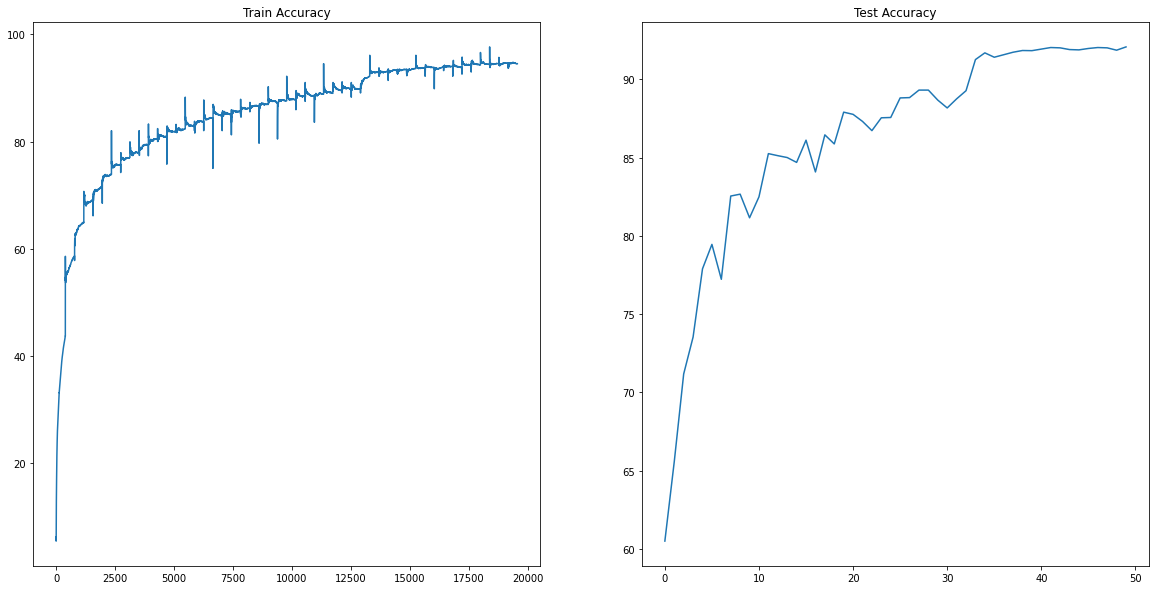

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(train_acc)
axs[0].set_title("Train Accuracy")


axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

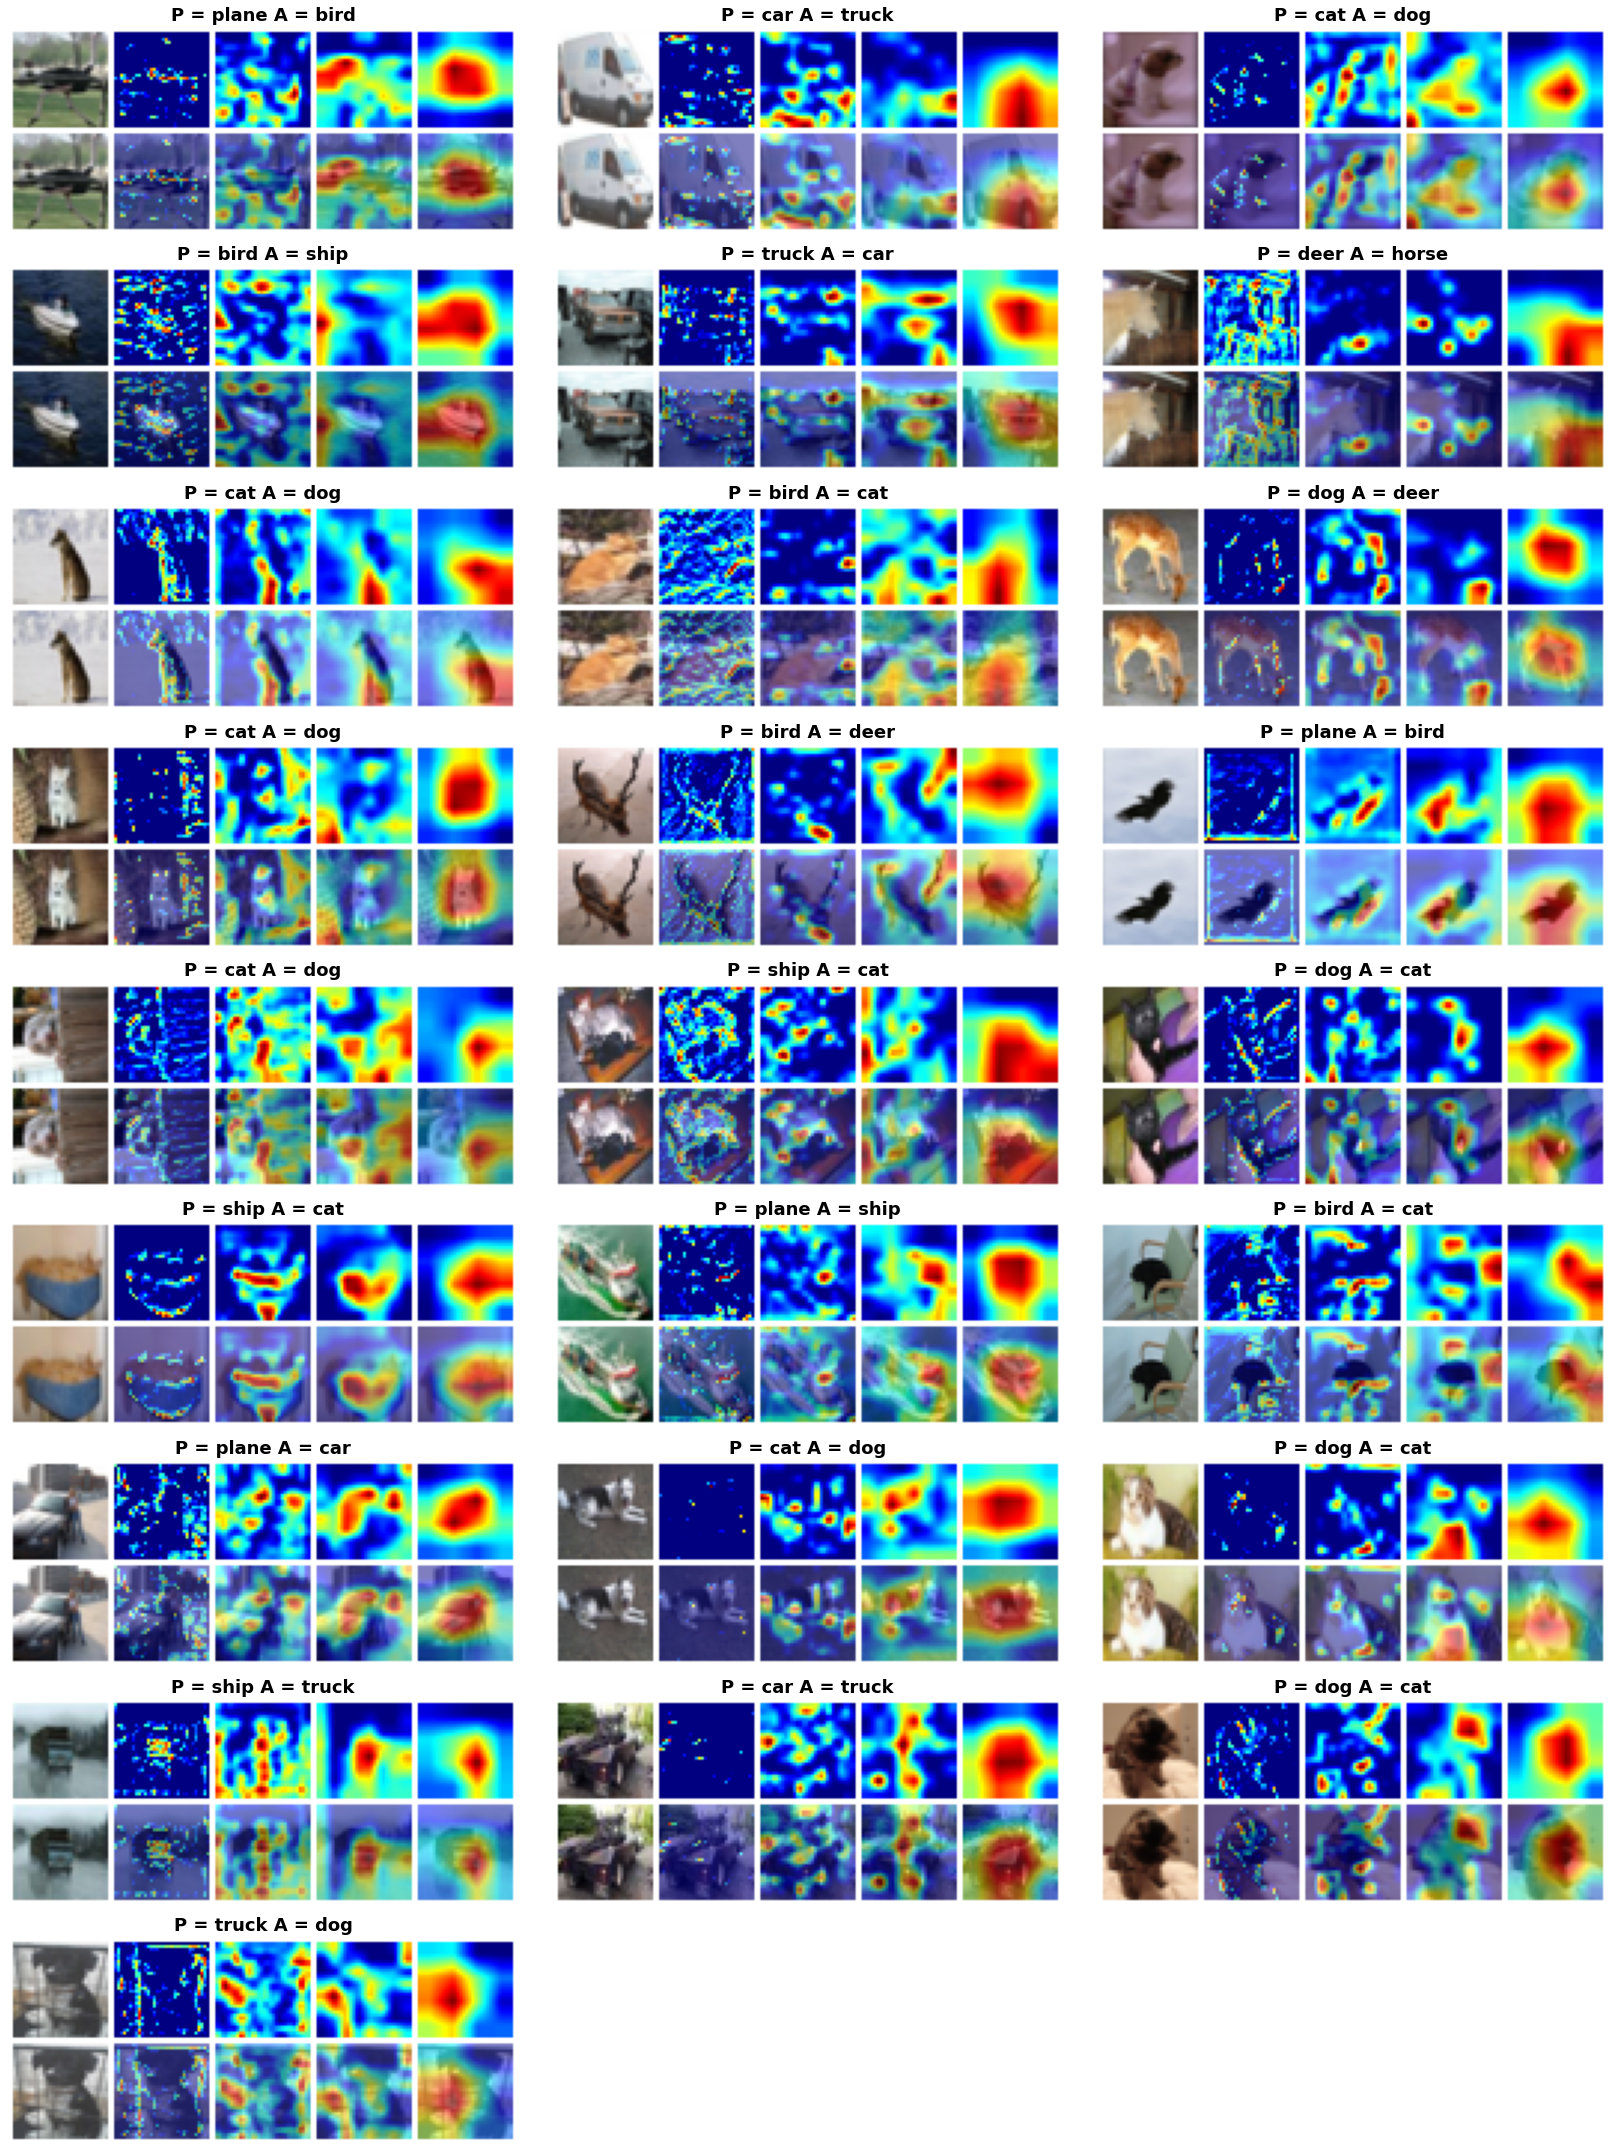

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1,resnet.layer2,resnet.layer3,resnet.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)